## XGBOOST Workflow: Predicting MIR100HG Expression in PAAD

This section outlines the complete XGBoost-based classification pipeline for predicting high vs. low expression of the lncRNA **MIR100HG** in PAAD (pancreatic adenocarcinoma) using integrated gene expression and DNA methylation data.

### 1. Data Preparation

- **Data Sources**:  
  Three data files were used:
  - Expression labels: `PAAD_Model_MIR100HG_Expression_Levels.csv`
  - Gene expression features: `PAAD_Model_Gene_Expression_Features.csv`
  - Methylation features: `PAAD_Model_Methylation_Features.csv`

- **Sample Filtering**:  
  Only samples shared by all datasets were retained (n = 178). MIR100HG was excluded from features to avoid target leakage.

- **Feature Annotation**:  
  Gene expression features were prefixed with `Gene_` and methylation features with `Methylation_`.

---

### 2. Dataset Split

The dataset was split into a training set (80%, n = 142) and a test set (20%, n = 36), stratified by MIR100HG expression group (high vs. low).

---

### 3. Feature Selection

Feature selection was performed only on the training data:

- **ANOVA F-test** was used to select:
  - Top 200 gene expression features
  - Top 100 methylation features

Selected features were applied to both training and test sets.

---

### 4. Model Training

- **Model**: `XGBoostClassifier` from `xgboost`
- **Parameters**:
  - `max_depth=2`, `n_estimators=50`
  - `learning_rate=0.05`, `reg_alpha=1.0`, `reg_lambda=3.0`
  - `subsample=0.8`, `colsample_bytree=0.8`
  - `random_state=42`

The model was trained on the selected features from the training set.

---

### 5. Feature Importance Analysis

- Feature importances were extracted from the trained model.
- Importance was reported as a percentage of total.
- Separate analysis was performed for:
  - Gene expression features
  - Methylation features

Bar plots and CSVs were generated for the top 20 features and grouped importance proportions.

---

### 6. Model Evaluation on Test Set

The test set was evaluated using:
- **Classification Metrics**: Accuracy, Precision, Recall, F1-score, ROC-AUC
- **Visualization**:
  - Confusion matrix
  - Precision-recall curve
  - Feature type importance chart

---

### 7. Cross-Validation

5-fold stratified cross-validation was conducted to assess model robustness. For each fold:
- Feature selection was re-applied
- A new XGBoost model was trained
- Performance metrics were recorded:
  - Accuracy, Precision, Recall, F1-score, ROC-AUC
- Feature importance per fold was saved

Average metrics across folds were calculated and reported.

---

### 8. Visualization

All key outputs were visualized and saved, including:
- Top 20 feature importances (bar plot)
- Confusion matrix heatmap
- Precision-recall curve
- Feature source importance breakdown

---

### Output

All results (metrics, visualizations, feature rankings) were saved to the specified output directory:
`D:\project data\M-28\NTU_DATA_MODEL\PAAD_XGBoost`



The expression data shape of MIR100HG: (178, 4)
Gene expression data shape: (3317, 178)
Methylated data shape: (10248, 185)
Number of common sample: 178
Label count: Group
Low     89
High    89
Name: count, dtype: int64
Delete MIR100HG to prevent tag leakage
The number of training set samples: 142
The number of test set samples: 36
Before feature selection:
The quantity of gene expression characteristics: 3316
The number of methylation characteristics: 10248
The number of gene expression characteristics selected by ANOVA: 200
The number of methylated features selected by ANOVA: 100
The total number of selected features: 300

 Train XGBoost...

Analyze the importance of characteristics...

Percentage of feature importance:
Gene expression features: 84.50%
Methylation features: 15.50%

Top20 features of gene expression:
      Feature  Percentage
  Gene_DNM3OS    8.520131
  Gene_TCEAL7    7.621478
  Gene_DPYSL3    5.259591
   Gene_MXRA7    4.983198
    Gene_DKK3    4.621003
   Gene_FXYD6 

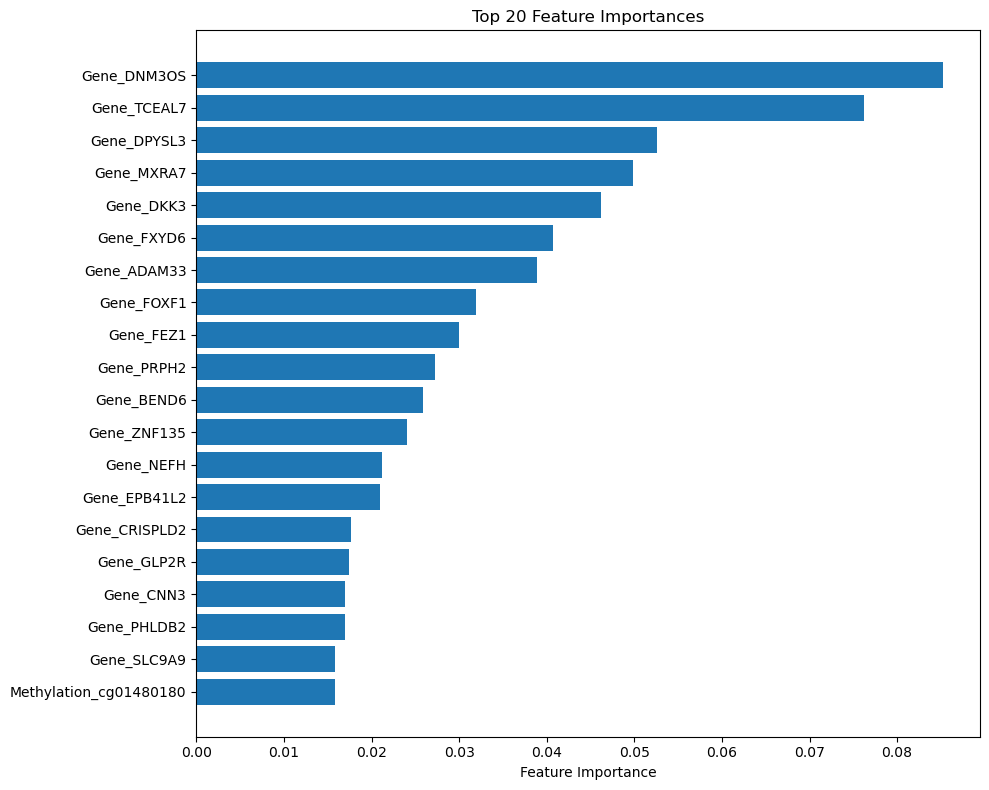

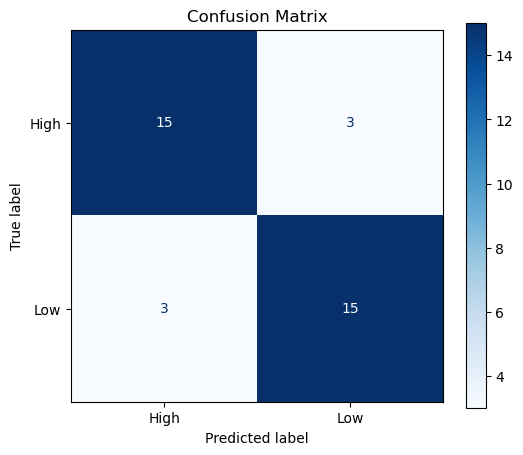

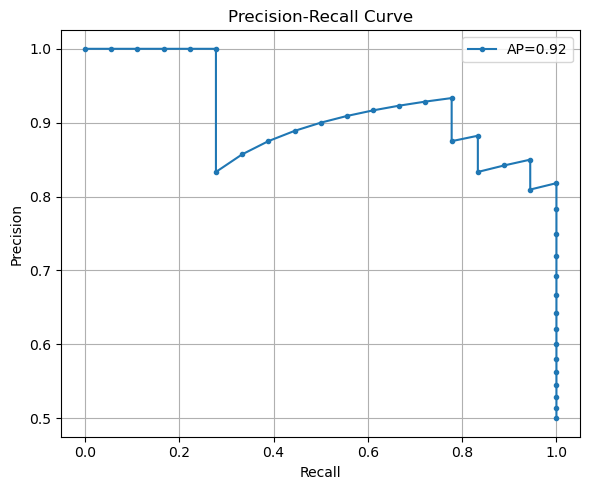

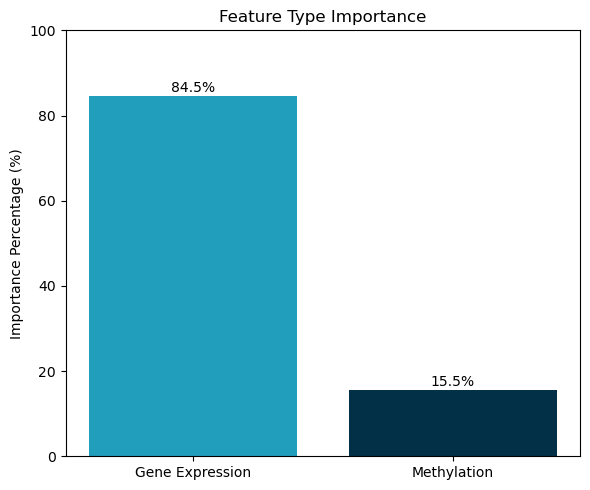


Analysis completed! All results have been saved to: D:\project data\M-28\NTU_DATA_MODEL\PAAD_XGBoost


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix, precision_recall_curve, average_precision_score, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import xgboost as xgb
import os

# Set the output directory
output_dir = r'D:\project data\M-28\NTU_DATA_MODEL\PAAD_XGBoost'
os.makedirs(output_dir, exist_ok=True)

# ========================
# 1. Read data
# ========================
input_dir = r'D:\project data\M-28\NTU_DATA_CLEANED\\'
label_df = pd.read_csv(f'{input_dir}PAAD_Model_MIR100HG_Expression_Levels.csv')
gene_expr_df = pd.read_csv(f'{input_dir}PAAD_Model_Gene_Expression_Features.csv', index_col=0)
methylation_df = pd.read_csv(f'{input_dir}PAAD_Model_Methylation_Features.csv', index_col=0)

print("The expression data shape of MIR100HG:", label_df.shape)
print("Gene expression data shape:", gene_expr_df.shape)
print("Methylated data shape:", methylation_df.shape)

# ========================
# 2. Transpose the feature data
# ========================
gene_expr_df_t = gene_expr_df.T
methylation_df_t = methylation_df.T

# ========================
# 3. Take public samples
# ========================
common_samples = list(set(gene_expr_df_t.index) & set(methylation_df_t.index))
gene_expr_df_t = gene_expr_df_t.loc[common_samples]
methylation_df_t = methylation_df_t.loc[common_samples]

print(f"Number of common sample: {len(common_samples)}")

# ========================
# 4. Label handling
# ========================
label_df = label_df.set_index("Sample_ID")
label_df = label_df.reindex(gene_expr_df_t.index)
y = label_df["Group"]
le = LabelEncoder()
y_encoded = le.fit_transform(y)

print(f"Label count: {pd.Series(y).value_counts()}")

# Delete MIR100HG to prevent tag leakage
if 'MIR100HG' in gene_expr_df_t.columns:
    print("Delete MIR100HG to prevent tag leakage")
    gene_expr_df_t = gene_expr_df_t.drop(columns=['MIR100HG'])

# ========================
# 5. Add characteristic prefixes
# ========================
# Add prefixes to gene expression and methylation characteristics
gene_expr_df_t = gene_expr_df_t.add_prefix('Gene_')
methylation_df_t = methylation_df_t.add_prefix('Methylation_')

# ========================
# 6. Division training test set
# ========================
X_train_full, X_test, y_train_full, y_test = train_test_split(
    pd.concat([gene_expr_df_t, methylation_df_t], axis=1), 
    y_encoded, 
    test_size=0.2, 
    random_state=42,
    stratify=y_encoded
)

print(f"The number of training set samples: {X_train_full.shape[0]}")
print(f"The number of test set samples: {X_test.shape[0]}")

# ========================
# 7. Feature selection function
# ========================
def select_features(X_train, y_train, k_gene=200, k_meth=100, var_threshold=0.005):
    # Isolate the characteristics of gene expression and methylation
    gene_columns = [col for col in X_train.columns if col.startswith('Gene_')]
    meth_columns = [col for col in X_train.columns if col.startswith('Methylation_')]
    
    X_train_gene = X_train[gene_columns]
    X_train_meth = X_train[meth_columns]
    
    print("Before feature selection:")
    print(f"The quantity of gene expression characteristics: {len(gene_columns)}")
    print(f"The number of methylation characteristics: {len(meth_columns)}")
    
    # The ANOVA F test was conducted on the gene expression characteristics
    k_gene_actual = min(k_gene, len(gene_columns))
    selector_gene = SelectKBest(score_func=f_classif, k=k_gene_actual)
    gene_selected = selector_gene.fit_transform(X_train_gene, y_train)
    gene_selected_cols = X_train_gene.columns[selector_gene.get_support(indices=True)]
    
    # The ANOVA F test was conducted on the methylation characteristics
    k_meth_actual = min(k_meth, len(meth_columns))
    selector_meth = SelectKBest(score_func=f_classif, k=k_meth_actual)
    meth_selected = selector_meth.fit_transform(X_train_meth, y_train)
    meth_selected_cols = X_train_meth.columns[selector_meth.get_support(indices=True)]
    
    print(f"The number of gene expression characteristics selected by ANOVA: {len(gene_selected_cols)}")
    print(f"The number of methylated features selected by ANOVA: {len(meth_selected_cols)}")
    
    # Create DataFrame
    gene_selected_df = pd.DataFrame(gene_selected, index=X_train.index, columns=gene_selected_cols)
    meth_selected_df = pd.DataFrame(meth_selected, index=X_train.index, columns=meth_selected_cols)
    
    # Combine all selected features
    X_train_selected = pd.concat([gene_selected_df, meth_selected_df], axis=1)
    
    # Return the selected features and column names
    return X_train_selected, gene_selected_cols.tolist(), meth_selected_cols.tolist()

# ========================
# 8. Select features on training set
# ========================
X_train_selected, gene_selected_cols, meth_selected_cols = select_features(X_train_full, y_train_full)
print(f"The total number of selected features: {X_train_selected.shape[1]}")

# Apply feature selection to the test set
X_test_selected = X_test[gene_selected_cols + meth_selected_cols]

# ========================
# 9. Train XGBoost
# ========================
print("\n Train XGBoost...")
model = xgb.XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    reg_alpha=1.0,
    reg_lambda=3.0,
    max_depth=2,
    n_estimators=50,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model.fit(X_train_selected, y_train_full)

# ========================
# 10. Feature Importance Analysis
# ========================
def analyze_feature_importance(model, feature_names):
    importances = model.feature_importances_
    
    # Create a DataFrame to store the importance of features
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    })
    
    # Sort by importance
    feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)
    
    # Calculate the percentage
    feature_importance_df['Percentage'] = feature_importance_df['Importance'] / feature_importance_df['Importance'].sum() * 100
    
    return feature_importance_df

# Analyze the importance of characteristics
print("\nAnalyze the importance of characteristics...")
feature_importance = analyze_feature_importance(model, X_train_selected.columns)

# Classify the features and calculate the total importance of each type of feature
gene_importance = feature_importance[feature_importance['Feature'].str.startswith('Gene_')]
methylation_importance = feature_importance[feature_importance['Feature'].str.startswith('Methylation_')]

gene_importance_sum = gene_importance['Importance'].sum()
methylation_importance_sum = methylation_importance['Importance'].sum()
total_importance = gene_importance_sum + methylation_importance_sum

# Print feature importance statistics
print("\nPercentage of feature importance:")
print(f"Gene expression features: {gene_importance_sum / total_importance * 100:.2f}%")
print(f"Methylation features: {methylation_importance_sum / total_importance * 100:.2f}%")

# Print the Top20 features grouped by category
print("\nTop20 features of gene expression:")
print(gene_importance.head(20)[['Feature', 'Percentage']].to_string(index=False))

print("\nTop20 features of gene expression:")
print(methylation_importance.head(20)[['Feature', 'Percentage']].to_string(index=False))

print("\nOverall Top20 features:")
print(feature_importance.head(20)[['Feature', 'Percentage']].to_string(index=False))

# Overall Top20 features
gene_importance.to_csv(os.path.join(output_dir, 'PAAD_XGBoost_Gene_Importance.csv'), index=False)
methylation_importance.to_csv(os.path.join(output_dir, 'PAAD_XGBoost_Methylation_Importance.csv'), index=False)
feature_importance.to_csv(os.path.join(output_dir, 'PAAD_XGBoost_All_Features_Importance.csv'), index=False)

# ========================
# 11. Evaluate the model on the test set
# ========================
print("\nEvaluate the model on the test set...")
y_pred = model.predict(X_test_selected)
y_proba = model.predict_proba(X_test_selected)[:, 1]

# Calculate evaluation index
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)
cm = confusion_matrix(y_test, y_pred)

# Print the assessment results
print("\nPrint the assessment index:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"AUC: {auc:.4f}")
print("Confusion matrix:")
print(cm)
print(classification_report(y_test, y_pred, target_names=le.classes_))

# ========================
# 12. Cross-validation
# ========================
print("\nCross-validation...")
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_results = {
    'fold': [],
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'auc': []
}

X_full = pd.concat([gene_expr_df_t, methylation_df_t], axis=1)
fold = 1

for train_idx, val_idx in skf.split(X_full, y_encoded):
    print(f"\n Perform {fold} Cross-validation...")
    
    # Obtain the current training and validation data of fold
    X_fold_train, X_fold_val = X_full.iloc[train_idx], X_full.iloc[val_idx]
    y_fold_train, y_fold_val = y_encoded[train_idx], y_encoded[val_idx]
    
    # Feature selection in fold
    print(f"Fold {fold} - Feature selection...")
    X_fold_train_selected, fold_gene_cols, fold_meth_cols = select_features(X_fold_train, y_fold_train)
    X_fold_val_selected = X_fold_val[fold_gene_cols + fold_meth_cols]
    
    # Train
    print(f"Fold {fold} - Train model...")
    fold_model = xgb.XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        reg_alpha=1.0,
        reg_lambda=3.0,
        max_depth=2,
        n_estimators=50,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )
    fold_model.fit(X_fold_train_selected, y_fold_train)
    
    # Prediction
    y_fold_pred = fold_model.predict(X_fold_val_selected)
    y_fold_prob = fold_model.predict_proba(X_fold_val_selected)[:, 1]
    
    # Calculate performance index
    fold_accuracy = accuracy_score(y_fold_val, y_fold_pred)
    fold_precision = precision_score(y_fold_val, y_fold_pred)
    fold_recall = recall_score(y_fold_val, y_fold_pred)
    fold_f1 = f1_score(y_fold_val, y_fold_pred)
    fold_auc = roc_auc_score(y_fold_val, y_fold_prob)
    
    # Print this fold result
    print(f"Fold {fold} - Performance index:")
    print(f"  Accuracy: {fold_accuracy:.4f}")
    print(f"  Percision: {fold_precision:.4f}")
    print(f"  Recall: {fold_recall:.4f}")
    print(f"  F1-score: {fold_f1:.4f}")
    print(f"  AUC: {fold_auc:.4f}")
    
    # Preserve results
    cv_results['fold'].append(fold)
    cv_results['accuracy'].append(fold_accuracy)
    cv_results['precision'].append(fold_precision)
    cv_results['recall'].append(fold_recall)
    cv_results['f1'].append(fold_f1)
    cv_results['auc'].append(fold_auc)
    
    # Analyze the importance of features
    fold_importance = analyze_feature_importance(fold_model, X_fold_train_selected.columns)
    
    # Preserve the feature importance of this fold
    fold_importance.to_csv(os.path.join(output_dir, f'PAAD_XGBoost_Fold{fold}_Feature_Importance.csv'), index=False)
    
    fold += 1

# Calculate the average performance of cross-validation
cv_results_df = pd.DataFrame(cv_results)
cv_mean = cv_results_df.mean()

print("\nCalculate the average performance of cross-validation:")
print(f"Mean accuracy: {cv_mean['accuracy']:.4f}")
print(f"Mean percision: {cv_mean['precision']:.4f}")
print(f"Mean recall: {cv_mean['recall']:.4f}")
print(f"Mean F1-score: {cv_mean['f1']:.4f}")
print(f"Mean AUC: {cv_mean['auc']:.4f}")

# Save the cross-validation results
cv_results_df.to_csv(os.path.join(output_dir, 'PAAD_XGBoost_CV_Results.csv'), index=False)

# ========================
# 13. Visualization
# ========================
# Feature importance bar chart - Top 20
plt.figure(figsize=(10, 8))
indices = np.argsort(feature_importance['Importance'])[-20:][::-1]
plt.barh(range(20), feature_importance['Importance'].iloc[indices], align='center')
plt.yticks(range(20), feature_importance['Feature'].iloc[indices])
plt.xlabel('Feature Importance')
plt.title('Top 20 Feature Importances')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'Top20_Feature_Importance.png'))
plt.show()

# Confusion matrix heat map
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(ax=ax, cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.savefig(os.path.join(output_dir, 'Confusion_Matrix.png'))
plt.show()

# Precision - recall curve
precision, recall, _ = precision_recall_curve(y_test, y_proba)
avg_precision = average_precision_score(y_test, y_proba)
plt.figure(figsize=(6, 5))
plt.plot(recall, precision, marker='.', label=f'AP={avg_precision:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'Precision_Recall_Curve.png'))
plt.show()

# The proportion of importance of various characteristics
plt.figure(figsize=(6, 5))
plt.bar(['Gene Expression', 'Methylation'], 
        [gene_importance_sum / total_importance * 100, 
         methylation_importance_sum / total_importance * 100],
        color=['#219ebc', '#023047'])
plt.title("Feature Type Importance")
plt.ylabel("Importance Percentage (%)")
plt.ylim(0, 100)
for i, v in enumerate([gene_importance_sum / total_importance * 100, 
                       methylation_importance_sum / total_importance * 100]):
    plt.text(i, v + 1, f"{v:.1f}%", ha='center')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'Feature_Type_Importance.png'))
plt.show()

print("\nAnalysis completed! All results have been saved to:", output_dir)

# Predicting MIR100HG Expression Status in PAAD Using XGBoost

## 1. Data Summary

| Data Type         | Description                               | Samples | Features |
|-------------------|-------------------------------------------|---------|----------|
| Expression Labels | MIR100HG expression status (high/low)     | 178     | 4        |
| Gene Expression   | Gene expression features                  | 3317    | 178      |
| Methylation       | DNA methylation features                  | 10248   | 185      |

---

## 2. Data Preprocessing

| Step                       | Description                                                                |
|----------------------------|-----------------------------------------------------------------------------|
| Label Cleaning             | Removed `MIR100HG` feature to prevent target leakage                        |
| Sample Filtering           | Retained 178 samples common to all datasets                                 |
| Feature Summary            | Gene expression: 3316 features; Methylation: 10248 features                 |
| Feature Prefixing          | Added prefix `Gene_` to expression features and `Methylation_` to methylation |

---

## 3. Dataset Split

| Dataset     | Sample Count |
|-------------|--------------|
| Training    | 142          |
| Testing     | 36           |

---

## 4. Feature Selection (Training Set Only)

| Step                  | Gene Expression | Methylation | Total |
|-----------------------|------------------|-------------|--------|
| After ANOVA Selection | 200              | 100         | 300    |

---

## 5. Model Training: XGBoost

---

## 6. Feature Importance Analysis

### Feature Source Proportion

| Feature Type     | Percentage |
|------------------|------------|
| Gene Expression  | 84.50%     |
| Methylation      | 15.50%     |

### Top 20 Gene Expression Features

| Rank | Feature         | Percentage |
|------|------------------|------------|
| 1    | Gene_DNM3OS      | 8.52%      |
| 2    | Gene_TCEAL7      | 7.62%      |
| 3    | Gene_DPYSL3      | 5.26%      |
| 4    | Gene_MXRA7       | 4.98%      |
| 5    | Gene_DKK3        | 4.62%      |
| ...  | ...              | ...        |
| 20   | Gene_SMOC2       | 1.33%      |

### Top 20 Methylation Features

| Rank | Feature                   | Percentage |
|------|----------------------------|------------|
| 1    | Methylation_cg01480180    | 1.59%      |
| 2    | Methylation_cg24633312    | 1.21%      |
| 3    | Methylation_cg25966705    | 1.07%      |
| ...  | ...                       | ...        |
| 20   | Methylation_cg08469255    | 0.29%      |

---

## 7. Test Set Performance

| Metric     | Value   |
|------------|---------|
| Accuracy   | 0.8333  |
| Precision  | 0.8333  |
| Recall     | 0.8333  |
| F1-Score   | 0.8333  |
| AUC        | 0.9352  |

**Confusion Matrix**:

|              | Predicted Low | Predicted High |
|--------------|---------------|----------------|
| Actual Low   | 15            | 3              |
| Actual High  | 3             | 15             |

---

## 8. Cross-Validation (5-Fold)

| Fold | Accuracy | Precision | Recall | F1-Score | AUC    |
|------|----------|-----------|--------|----------|--------|
| 1    | 0.6944   | 0.6842    | 0.7222 | 0.7027   | 0.8241 |
| 2    | 0.7778   | 0.7778    | 0.7778 | 0.7778   | 0.9198 |
| 3    | 0.8889   | 0.9375    | 0.8333 | 0.8824   | 0.9444 |
| 4    | 0.8571   | 0.8824    | 0.8333 | 0.8571   | 0.9542 |
| 5    | 0.8857   | 0.8421    | 0.9412 | 0.8889   | 0.9706 |

### Mean Performance:

| Metric        | Value   |
|---------------|---------|
| Accuracy      | 0.8208  |
| Precision     | 0.8248  |
| Recall        | 0.8216  |
| F1-Score      | 0.8218  |
| AUC           | 0.9226  |

---


# Sort out the data that has not undergone DEG DMA processing


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix, precision_recall_curve, average_precision_score, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import xgboost as xgb
import os

# ========================
# 1. Read data
# ========================
input_dir = r'D:\project data\M-28\NTU_DATA_CLEANED\\'
label_df = pd.read_csv(f'{input_dir}PAAD_Model_MIR100HG_Expression_Levels.csv')
gene_expr_df = pd.read_csv(f'{input_dir}PAAD_Model_Gene_Expression_Features_Test.csv', index_col=0)
methylation_df = pd.read_csv(f'{input_dir}PAAD_Model_Methylation_Features_Test.csv', index_col=0)

print("The expression data shape of MIR100HG:", label_df.shape)
print("Gene expression data shape:", gene_expr_df.shape)
print("Methylated data shape:", methylation_df.shape)

# ========================
# 2. Transpose the feature data
# ========================
gene_expr_df_t = gene_expr_df.T
methylation_df_t = methylation_df.T

# ========================
# 3. Take public samples
# ========================
common_samples = list(set(gene_expr_df_t.index) & set(methylation_df_t.index))
gene_expr_df_t = gene_expr_df_t.loc[common_samples]
methylation_df_t = methylation_df_t.loc[common_samples]

print(f"Number of common samples: {len(common_samples)}")

# ========================
# 4. Label handling
# ========================
label_df = label_df.set_index("Sample_ID")
label_df = label_df.reindex(gene_expr_df_t.index)
y = label_df["Group"]
le = LabelEncoder()
y_encoded = le.fit_transform(y)

print(f"Label count: {pd.Series(y).value_counts()}")

# Delete MIR100HG to prevent tag leakage
if 'MIR100HG' in gene_expr_df_t.columns:
    print("Delete MIR100HG to prevent tag leakage")
    gene_expr_df_t = gene_expr_df_t.drop(columns=['MIR100HG'])

# ========================
# 5. Add characteristic prefixes
# ========================
# Add prefixes to gene expression and methylation characteristics
gene_expr_df_t = gene_expr_df_t.add_prefix('Gene_')
methylation_df_t = methylation_df_t.add_prefix('Methylation_')

# ========================
# 6. Divide the training test set
# ========================
X_train_full, X_test, y_train_full, y_test = train_test_split(
    pd.concat([gene_expr_df_t, methylation_df_t], axis=1), 
    y_encoded, 
    test_size=0.2, 
    random_state=42,
    stratify=y_encoded
)

print(f"The number of training set samples: {X_train_full.shape[0]}")
print(f"The number of test set samples: {X_test.shape[0]}")

# ========================
# 7. Feature selection function
# ========================
def select_features(X_train, y_train, k_gene=200, k_meth=100, var_threshold=0.005):
    # Isolate the characteristics of gene expression and methylation
    gene_columns = [col for col in X_train.columns if col.startswith('Gene_')]
    meth_columns = [col for col in X_train.columns if col.startswith('Methylation_')]
    
    X_train_gene = X_train[gene_columns]
    X_train_meth = X_train[meth_columns]
    
    print("Before feature selection:")
    print(f"The quantity of gene expression features: {len(gene_columns)}")
    print(f"The quantity of methylation features: {len(meth_columns)}")
    
    # The ANOVA F test was conducted on the gene expression characteristics
    k_gene_actual = min(k_gene, len(gene_columns))
    selector_gene = SelectKBest(score_func=f_classif, k=k_gene_actual)
    gene_selected = selector_gene.fit_transform(X_train_gene, y_train)
    gene_selected_cols = X_train_gene.columns[selector_gene.get_support(indices=True)]
    
    # The ANOVA F test was conducted on the methylation characteristics
    k_meth_actual = min(k_meth, len(meth_columns))
    selector_meth = SelectKBest(score_func=f_classif, k=k_meth_actual)
    meth_selected = selector_meth.fit_transform(X_train_meth, y_train)
    meth_selected_cols = X_train_meth.columns[selector_meth.get_support(indices=True)]
    
    print(f"The number of gene expression characteristics selected by ANOVA: {len(gene_selected_cols)}")
    print(f"The number of methylated features selected by ANOVA: {len(meth_selected_cols)}")
    
    # DataFrame
    gene_selected_df = pd.DataFrame(gene_selected, index=X_train.index, columns=gene_selected_cols)
    meth_selected_df = pd.DataFrame(meth_selected, index=X_train.index, columns=meth_selected_cols)
    
    # Merge the selected features
    X_train_selected = pd.concat([gene_selected_df, meth_selected_df], axis=1)
    
    # Merge the selected features
    return X_train_selected, gene_selected_cols.tolist(), meth_selected_cols.tolist()

# ========================
# 8. Feature selection is performed on the training set
# ========================
X_train_selected, gene_selected_cols, meth_selected_cols = select_features(X_train_full, y_train_full)
print(f"The total number of selected features: {X_train_selected.shape[1]}")

# Apply feature selection to the test set
X_test_selected = X_test[gene_selected_cols + meth_selected_cols]

# ========================
# 9. Train XGBoost
# ========================
print("\nTain XGBoost model...")
model = xgb.XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    reg_alpha=1.0,
    reg_lambda=3.0,
    max_depth=2,
    n_estimators=50,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model.fit(X_train_selected, y_train_full)

# ========================
# 10. Feature Importance Analysis
# ========================
def analyze_feature_importance(model, feature_names):
    importances = model.feature_importances_
    
    # Create a DataFrame to store the importance of features
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    })
    
    # Sort by importance
    feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)
    
    # Calculate the percentage
    feature_importance_df['Percentage'] = feature_importance_df['Importance'] / feature_importance_df['Importance'].sum() * 100
    
    return feature_importance_df

# Analyze the importance of characteristics
print("\nAnalyze the importance of characteristics...")
feature_importance = analyze_feature_importance(model, X_train_selected.columns)

# Classify the features and calculate the total importance of each type of feature
gene_importance = feature_importance[feature_importance['Feature'].str.startswith('Gene_')]
methylation_importance = feature_importance[feature_importance['Feature'].str.startswith('Methylation_')]

gene_importance_sum = gene_importance['Importance'].sum()
methylation_importance_sum = methylation_importance['Importance'].sum()
total_importance = gene_importance_sum + methylation_importance_sum

#  Print the importance of selected features
print("\nPercentage of feature importance:")
print(f"Gene expression characteristics: {gene_importance_sum / total_importance * 100:.2f}%")
print(f"Methylation characteristics: {methylation_importance_sum / total_importance * 100:.2f}%")

# Print the Top20 features grouped by category
print("\nTop20 features of gene expression:")
print(gene_importance.head(20)[['Feature', 'Percentage']].to_string(index=False))

print("\nTop20 features of methylation:")
print(methylation_importance.head(20)[['Feature', 'Percentage']].to_string(index=False))

print("\nOverall Top20 features:")
print(feature_importance.head(20)[['Feature', 'Percentage']].to_string(index=False))

# ========================
# 11. Evaluate the model on the test set
# ========================
print("\nEvaluate the model on the test set...")
y_pred = model.predict(X_test_selected)
y_proba = model.predict_proba(X_test_selected)[:, 1]

# Calculate various evaluation indicators
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)
cm = confusion_matrix(y_test, y_pred)

# Print evaluation results
print("\nPerformance evaluation index:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"AUC: {auc:.4f}")
print("Confusion matrix:")
print(cm)
print(classification_report(y_test, y_pred, target_names=le.classes_))

# ========================
# 12. Cross validation
# ========================
print("\ncross validation...")
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_results = {
    'fold': [],
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'auc': []
}

X_full = pd.concat([gene_expr_df_t, methylation_df_t], axis=1)
fold = 1

for train_idx, val_idx in skf.split(X_full, y_encoded):
    print(f"\nPerform {fold} fold cross validation...")
    
    # Obtain the current training and validation data of fold
    X_fold_train, X_fold_val = X_full.iloc[train_idx], X_full.iloc[val_idx]
    y_fold_train, y_fold_val = y_encoded[train_idx], y_encoded[val_idx]
    
    # Feature selection is performed within the fold
    print(f"Fold {fold} - features selection...")
    X_fold_train_selected, fold_gene_cols, fold_meth_cols = select_features(X_fold_train, y_fold_train)
    X_fold_val_selected = X_fold_val[fold_gene_cols + fold_meth_cols]
    
    # Train model
    print(f"Fold {fold} - train model...")
    fold_model = xgb.XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        reg_alpha=1.0,
        reg_lambda=3.0,
        max_depth=2,
        n_estimators=50,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )
    fold_model.fit(X_fold_train_selected, y_fold_train)
    
    # Prediction
    y_fold_pred = fold_model.predict(X_fold_val_selected)
    y_fold_prob = fold_model.predict_proba(X_fold_val_selected)[:, 1]
    
    # Calculate performance index
    fold_accuracy = accuracy_score(y_fold_val, y_fold_pred)
    fold_precision = precision_score(y_fold_val, y_fold_pred)
    fold_recall = recall_score(y_fold_val, y_fold_pred)
    fold_f1 = f1_score(y_fold_val, y_fold_pred)
    fold_auc = roc_auc_score(y_fold_val, y_fold_prob)
    
    # Print the result of this fold
    print(f"Fold {fold} - Performance index:")
    print(f"  Accuracy: {fold_accuracy:.4f}")
    print(f"  Precision: {fold_precision:.4f}")
    print(f"  Recall: {fold_recall:.4f}")
    print(f"  F1-score: {fold_f1:.4f}")
    print(f"  AUC: {fold_auc:.4f}")
    
    # Save results
    cv_results['fold'].append(fold)
    cv_results['accuracy'].append(fold_accuracy)
    cv_results['precision'].append(fold_precision)
    cv_results['recall'].append(fold_recall)
    cv_results['f1'].append(fold_f1)
    cv_results['auc'].append(fold_auc)
    
    # Analyze the importance of features
    fold_importance = analyze_feature_importance(fold_model, X_fold_train_selected.columns)
    
    # Preserve
    fold_importance.to_csv(os.path.join(output_dir, f'PAAD_XGBoost_Fold{fold}_Feature_Importance.csv'), index=False)
    
    fold += 1

# Calculate the average performance of cross-validation
cv_results_df = pd.DataFrame(cv_results)
cv_mean = cv_results_df.mean()

print("\nMean performance of cross-validation:")
print(f"Mean accuracy: {cv_mean['accuracy']:.4f}")
print(f"Mean percision: {cv_mean['precision']:.4f}")
print(f"Mean recall: {cv_mean['recall']:.4f}")
print(f"Mean F1-score: {cv_mean['f1']:.4f}")
print(f"Mean AUC: {cv_mean['auc']:.4f}")





The expression data shape of MIR100HG: (178, 4)
Gene expression data shape: (40060, 178)
Methylated data shape: (374096, 185)
Number of common samples: 178
Label count: Group
Low     89
High    89
Name: count, dtype: int64
Delete MIR100HG to prevent tag leakage
The number of training set samples: 142
The number of test set samples: 36
Before feature selection:
The quantity of gene expression features: 40059
The quantity of methylation features: 374096
The number of gene expression characteristics selected by ANOVA: 200
The number of methylated features selected by ANOVA: 100
The total number of selected features: 300

Tain XGBoost model...

Analyze the importance of characteristics...

Percentage of feature importance:
Gene expression characteristics: 79.83%
Methylation characteristics: 20.17%

Top20 features of gene expression:
      Feature  Percentage
  Gene_DNM3OS    7.690123
  Gene_TCEAL7    5.917740
   Gene_MXRA7    5.651321
   Gene_FOXF1    5.358490
    Gene_DKK3    5.065012
  G